## Notes

_**Please note that the majority of the code related to the actual learning is mostly adapted from https://hoit1302.tistory.com/159 sans some cleanup and modifications to make it work!**_

### Struggles and sufferings
* KoBERT uses various outdated libraries (gluonnlp), which necessitates the use of Python 3.7.x
    * (Python 3.7.3 was used, however the *absolute final* release is 3.7.17.)
    * See https://linuxize.com/post/how-to-install-python-3-7-on-debian-9/ for instructions.
    * Also, IMO the `--enable-optimizations` is not necessary. It runs some tests after building Python to collect PGO (profile-guided optimisation) data, which in theory can make the code run faster, but also comes at a very high cost during the initial compilation (apparently takes hours). Since our code is mostly GPU-intensive it isn't worth the time.
    * (By the way, the issue is something to do with deprecated syntax (supposedly was a bug originally) that eventually got patched out on 3.8)
* You also need python3-dev because there are libraries with native components that compile from C (can't remember which)
* This necessitates the use of anything-other-than-colab, since you cannot really downgrade the python version of Colab
    * There are hacks that involve re-installing the system-wide installation of python, however that does not work, at least as of 2024 because Google Colab uses some Python scripts to connect, which uses syntax from Python 3.8+ (`:=`) and therefore would not work on 3.7
    * No colab would work. Period. Free tiers won't work, Pro tiers won't work, and Colab Enterprise won't work because of the same reason. (I tried.)
        * Perhaps someone with more Python / Jupyter / Linux knowledge might have better luck with it, at least I couldn't get it working
* Using [GCP provided 'Deep Learning VM images'](https://cloud.google.com/deep-learning-vm/docs/)
    * GCP gives you $300 free credit for 3 months, but you need to enable billing (i.e., allow GCP to steal your money off your wallet once the free credit runs dry) to use GPU
    * Once you enable billing, you need to 'request quota' for GPUs because that doesn't come standard??
        * [Filter by `compute.googleapis.com/gpus_all_regions`](https://console.cloud.google.com/iam-admin/quotas?hl=en&metric=compute.googleapis.com%2Fgpus_all_regions)
        * Click the three dot menu, and click 'edit quota'. You are prompted with a new value and the reason for requesting the quota increase.
        * I wrote something on the line of "Trying out natural language processing related machine-learning tasks"
        * It says it may take up to 2 business days but mine got through within minutes. You'll get a notification through your email when the request is approved
    * Provisioned on Compute Engine n1-highmem-2 (2 vCPUs, 12GB RAM) with 1x NVIDIA T4
        * Getting an instance is a pain since GPUs are on high demand thanks to the AI fad. Just retry in different regions until you get one. FWIW, I had success getting one from `southamerica-east1-c`
        * Might be a better idea to get more cores, since this involves various compilation from sources
    * Also - SSH'ing into the GCP is also a pain. Why does it have to be so hard??? I know it's because of enterprise-grade security but ugh.
    * Setting up the SSH key is unnecessarily complicated (something something 'OS login'), you can get SSH through the web browser but nobody wants that
    * `authorized_keys` gets constantly reset (supposedly something to do with the OS login thing), you can't even `sudo` through ssh unless you mess around with sudoers
* `transformers` relies on `tokenizers`, which has codes written in Rust
    * [Due to updated specs the source won't compile in newer versions of rust](https://github.com/huggingface/tokenizers/issues/1485#issuecomment-2040349997)
* NumPy also has to be on version 1.21.6 because some library uses numpy.bool which is deprecated in the latest version of NumPy and will raise error (can't remember which) and newer versions won't work on Python 3.7
* Since the KoBERT model itself is only available on HuggingFace, some of the sample codes available online won't work out of the box
    * Most of the ML-related Python codes come from https://hoit1302.tistory.com/159 which worked well enough (albeit with questionable programming choices, IMO)

Thanks VSCode w/ SSH extension for everything.

```bash
# Installing Python 3.7
# --- Installing build dependencies
sudo apt install build-essential zlib1g-dev libncurses5-dev libgdbm-dev libnss3-dev libssl-dev libreadline-dev libffi-dev curl libbz2-dev
# --- Download source tarball
curl -O https://www.python.org/ftp/python/3.7.17/Python-3.7.17.tar.xz
# --- Extract to folder
tar -xf Python-3.7.17.tar.xz
# --- Navigate to folder, then configure build, then build Python
# Note that this compilation will be missing lzma related bits - I will leave that as an exercise for readers (since I didn't need one, frankly)
# Pandas will complain on import about the missing lzma but it works fine as long as you don't use it
cd Python-3.7.17
./configure
make -j {CORE_COUNT} # !! change {CORE_COUNT} with core count. My machine has 2 so it'd be make -j 2
# Install python as python3.7. Check Python Version. Return to previous dir.
sudo make altinstall
python3.7 --version
cd ..

# Contains native headers for C-python interop. Used by safetensors (---> pandas I think?)
sudo apt install python3-dev
# Install Rust for tokenizers (---> transformers)
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
# Specify 1.72.1 to compile tokenizers. This may take a while because Rust...
rustup install 1.72.1
# I added --user when running pip install commands because I was getting hit with insufficient permission errors. Clearly I don't know much about it
RUSTUP_TOOLCHAIN=1.72.1 python3.7 -m pip install tokenizers==0.13.2
# Required for gluonnlp - it complains about something on the line of cython is 3.8+ only otherwise.
python3.7 -m pip install cython
# Latest numpy available on Python 3.7
python3.7 -m pip install numpy==1.21.6
python3.7 -m pip install transformers sentencepiece gluonnlp pandas mxnet torch ipywidgets scikit-learn
python3.7 -m pip install "git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf"
```

In [65]:
#
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm, tqdm_notebook
import pandas

# transformers.AdamW is deprecated.
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer


In [66]:
device = torch.device("cuda:0")

In [67]:
# Apparently this config can help with sentences without proper spaces.
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('skt/kobert-base-v1', sp_model_kwargs={'nbest_size': -1, 'alpha': 0.6, 'enable_sampling': True})
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [68]:
bertModel = BertModel.from_pretrained('skt/kobert-base-v1')

In [69]:
df = pandas.read_csv("./data_dcinside/transformed.csv", index_col=0)

In [7]:
labels = df["disasterKind"].unique()
labels

array(['none', 'earthquake', 'fire', 'sinkhole'], dtype=object)

array(['none', 'earthquake', 'fire', 'sinkhole'], dtype=object)

In [8]:
labelToInteger = {
    "none": 0,
    "earthquake": 1,
    "fire": 2,
    "sinkhole": 3
}

integerToLabel = {
    0: "none",
    1: "earthquake",
    2: "fire",
    3: "sinkhole"
}

df["disasterKind"] = df["disasterKind"].replace(labelToInteger)

In [9]:
df.dtypes

merged          object
disasterKind     int64
dtype: object

In [10]:
df.head()

,merged,disasterKind
0,2024년 12월 6일 미국지진 분석\nCA 깊이0.6km Ⅷ 쓰나미경보 ChatG...,0
1,2024년 11월 5일~2024년 12월 5일 30일간 미국지진 분석\n↓2024-...,0
2,"쿠바, 허리케인 끝나자 이번엔 규모 6.8 지진…""이런 지진은 처음""\n지진 후 1...",1
3,11월17일~12월 5일 일본지진 Chatgpt분석\n★ 오타로 인해 자료에 오류가...,0
5,님들아 제주도 지진 몆주간 계속 났는데 큰 지진 나나요?\n옛날에 자잘한 지진 계속...,0


In [11]:
data_list = []
for content, label in zip(df["merged"], df["disasterKind"]):
    data_list.append([content, label])


### Type Definition

In [12]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sentenceIndex, labelIndex, bert_tokenizer, vocab, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([data[sentenceIndex]]) for data in dataset]
        self.labels = [np.int32(data[labelIndex]) for data in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [13]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=len(labelToInteger), ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

### Training

In [14]:
# Setting parameters
max_len = 96
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [15]:
from sklearn.model_selection import train_test_split

# Due to very small amount of sample, we need to ensure that some of each label gets included
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=42, stratify=df["disasterKind"])

In [16]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [17]:
# Checking if the output is stratified correctly
trainDf = pandas.DataFrame(dataset_train, columns=["content", "label"])
trainDf["label"].value_counts()

0    734
2    108
3     53
1     29
Name: label, dtype: int64

In [18]:
# Checking if the output is stratified correctly
testDf = pandas.DataFrame(dataset_test, columns=["content", "label"])
testDf["label"].value_counts()

0    184
2     27
3     14
1      7
Name: label, dtype: int64

In [19]:
# Regarding num_workers:
# WARNING: This DataLoader will create {specified value} worker processes in total.
# Our suggested max number of worker in current system is {core count on system}, which is smaller than what this DataLoader is going to create.
# Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [20]:
#BERT 모델 불러오기
model = BERTClassifier(bertModel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

In [21]:
# On machine with NVIDIA T4:
# took 48.8s, max_len=64. test acc 0.82265625
# took 1m22s, max_len=96,  test acc 0.940625 < Chosen because it seems to be the largest model that can be used without running ot of VRAM
# took 1m43s, max-len=128, test acc 0.90703125
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

  0%|          | 0/15 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.3191807270050049 train acc 0.390625
epoch 1 train acc 0.6773809523809524


  0%|          | 0/4 [00:00<?, ?it/s]

epoch 1 test acc 0.79375


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.6914362907409668 train acc 0.8125
epoch 2 train acc 0.8186011904761905


  0%|          | 0/4 [00:00<?, ?it/s]

epoch 2 test acc 0.86328125


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5232982635498047 train acc 0.828125
epoch 3 train acc 0.8686011904761906


  0%|          | 0/4 [00:00<?, ?it/s]

epoch 3 test acc 0.91953125


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.42688438296318054 train acc 0.84375
epoch 4 train acc 0.9392857142857143


  0%|          | 0/4 [00:00<?, ?it/s]

epoch 4 test acc 0.95078125


  0%|          | 0/15 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.29965880513191223 train acc 0.921875
epoch 5 train acc 0.9590773809523809


  0%|          | 0/4 [00:00<?, ?it/s]

epoch 5 test acc 0.940625


In [64]:
torch.save(model.state_dict(), 'model_state_dict.pt')

### Evaluation

In [22]:
def predict(sentences):

    dataset_another = [[sentence, '0'] for sentence in sentences]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=2)
    
    model.eval()
    test_eval= []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        for i in out:
            logits = i
            logits = logits.detach().cpu().numpy()

            test_eval.append(integerToLabel[np.argmax(logits)])
    return test_eval


### Bogus analysis with whole of the dataset

In [23]:
predicted = predict(df["merged"].values)

In [24]:
predicted

['none',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'earthquake',
 'earthquake',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'none',
 'earthquake',
 'earthquake',
 'none',
 'earthquake',
 'earthquake',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'earthquake',
 'none',
 'none',
 'earthquake',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'earthquake',
 'none',
 'none',
 'earthquake',
 'earthquake',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'fire',
 'none',
 'earthquake',
 'none',
 'none',
 'earthquake',
 'none',
 'none',
 'none',
 'earthquake',
 'earthquake',
 'none',
 'none',
 'none',
 'earthqua

In [25]:
df["predicted"] = predicted

In [ ]:
df["disasterKind"] = df["disasterKind"].apply(lambda x: integerToLabel[x])

In [ ]:
unmatchedOrDisaster = df.loc[(df["disasterKind"] != "none") | (df["disasterKind"] != df["predicted"])]

In [36]:
unmatchedOrDisaster

,merged,disasterKind,predicted
2,"쿠바, 허리케인 끝나자 이번엔 규모 6.8 지진…""이런 지진은 처음""\n지진 후 1...",earthquake,earthquake
9,미 캘리포니아 북부해안 규모 7.0 지진후 여진 계속…‘비상사태’ 선포\n미국 캘리...,earthquake,earthquake
12,[일본] 미야기현 앞바다 지진\n지진 발생 당시 유튜브 실시간 방송 화면 https...,earthquake,earthquake
13,[일본] 이시카와현 서쪽 바다에서 지진\n지진 발생 당시 실시간 방송 화면 http...,earthquake,earthquake
21,지진 발생\n한국시간 12월 9일(월) 04:57 알류샨 열도를 진원으로 규모 6....,earthquake,earthquake
...,...,...,...
925,싱크홀 오우야\nnan,sinkhole,sinkhole
926,싱크홀ㅋㅋㅋㅋㅋㅋㅋㅋ\n- dc official App,sinkhole,sinkhole
927,싱크홀 ㅋㅋㅋㅋㅋㅋㅋㅋ\nnan,sinkhole,sinkhole
947,사상하단은 또 싱크홀이네.\nhttps://youtu.be/tm05yT8KWWk [...,sinkhole,sinkhole


In [40]:
from sklearn.metrics import accuracy_score
y_true = df["disasterKind"]
y_pred = df["predicted"]
accuracy_score(y_true, y_pred)

0.9610726643598616

In [41]:
accuracy_score(unmatchedOrDisaster["disasterKind"], unmatchedOrDisaster["predicted"])

0.8314606741573034

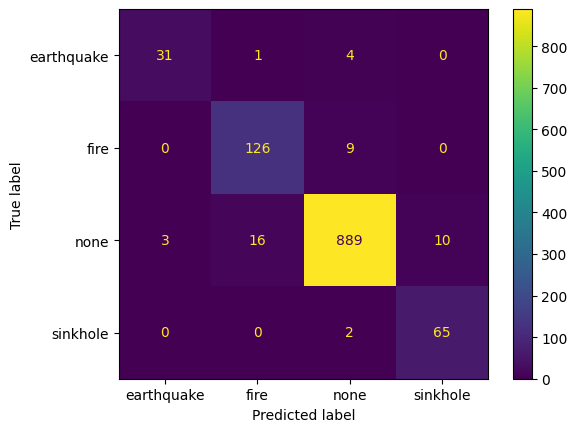

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

In [62]:
predict(["방금 지진임???\n흔들렸는데"])

['earthquake']

In [63]:
predict(["오는데 바닥에 땅꺼져있더라\n싱크홀 처음봄"])

['sinkhole']

## Evaluation with test sets only

In [87]:
testData = pandas.DataFrame(dataset_test, columns=["content", "actual"])
testData["actual"] = testData["actual"].apply(lambda x: integerToLabel[x])

In [88]:
testData.head()

,content,actual
0,깡담비이야기요약좀\n머하다불남 방송못봄,none
1,미친 미국 7.5 지진\nhttps://naver.me/5PVCFtdn [속보] 美...,earthquake
2,근데 기자도 웃긴게 왜 아본이 그 말을 하게되었는지\n갖고 와야지 ㅋㅋㅋㅋㅋㅋㅋㅋ ...,none
3,아니 근데 진격의 거인이랑 강철의 연금술사 뭐 비교하긴 좀 글치 않나?\n아니 근데...,none
4,싱글벙글 싱크홀이 생기는 과정\n의도했든 안했든 물웅덩이를 건드려서 물을 빼버림 ▶...,none


In [89]:
testData["predicted"] = predict(testData["content"])

In [90]:
testData

,content,actual,predicted
0,깡담비이야기요약좀\n머하다불남 방송못봄,none,none
1,미친 미국 7.5 지진\nhttps://naver.me/5PVCFtdn [속보] 美...,earthquake,earthquake
2,근데 기자도 웃긴게 왜 아본이 그 말을 하게되었는지\n갖고 와야지 ㅋㅋㅋㅋㅋㅋㅋㅋ ...,none,none
3,아니 근데 진격의 거인이랑 강철의 연금술사 뭐 비교하긴 좀 글치 않나?\n아니 근데...,none,none
4,싱글벙글 싱크홀이 생기는 과정\n의도했든 안했든 물웅덩이를 건드려서 물을 빼버림 ▶...,none,none
...,...,...,...
227,어제 화재난 부산 미군 55보급창.. 소파 협정으로 화재 원인 조사 못해\n샌드위치...,fire,fire
228,뭐야 오랜만에 왔는데 왜 갤 불남\n게임에서 호시노가 증식한다는 글이 간간히 보이는...,none,none
229,올시즌 좆같긴했어도 리스크 짊어지고 오뎅을 푸는건 병신짓이지 시발들아\n여기서나 꺼...,none,none
230,칸나의 빈자리는 영원히 메워지지 않을거야\n도로 한복판의 싱크홀처럼 스텔라이브를 지...,none,none


#### Accuracy

In [91]:
from sklearn.metrics import accuracy_score
y_true = testData["actual"]
y_pred = testData["predicted"]
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")

Accuracy: 0.9310344827586207


### Balanced Accuracy

In [92]:
from sklearn.metrics import balanced_accuracy_score
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred)}")

Balanced Accuracy: 0.9308574879227053


### Precision, Recall, F1 score, support

In [96]:
from sklearn.metrics import classification_report
labels=list(labelToInteger.keys())
print(classification_report(y_true, y_pred, labels=labels, digits=4))

              precision    recall  f1-score   support

        none     0.9667    0.9457    0.9560       184
  earthquake     0.8750    1.0000    0.9333         7
        fire     0.7778    0.7778    0.7778        27
    sinkhole     0.8235    1.0000    0.9032        14

    accuracy                         0.9310       232
   macro avg     0.8607    0.9309    0.8926       232
weighted avg     0.9333    0.9310    0.9314       232



### Confusion matrix

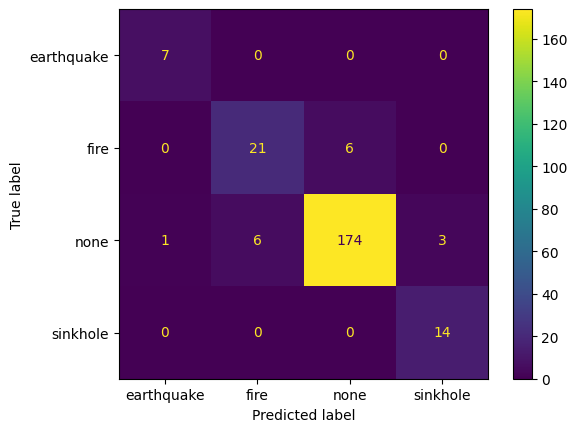

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)